# `TBTauModel` Tutorial

Trey V. Wenger (c) August 2024

Here we demonstrate the `TBTauModel` model. `TBTauModel` is like `TauModel`, except it also predicts the brightness temperature spectra for the 1612, 1665, 1667, and 1720 MHz hyperfine transitions of OH. This notebook is otherwise identical to the `TauModel` notebook.

In [1]:
# General imports
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import amoeba2
print("amoeba2 version:", amoeba2.__version__)

from amoeba2 import TBTauModel

# Notebook configuration
pd.options.display.max_rows = None
    
# random state
rng = np.random.RandomState(seed=1234)

pymc version: 5.16.2
bayes_spec version: 1.6.2+0.g883013c.dirty
amoeba2 version: 1.0.0-staging+2.g5fc8a50.dirty


## Simulating Data

To test the model, we must simulate some data. We can do this with `TBTauModel`, but we must pack a "dummy" data structure first. The model expects the observations to be named `"tau_1612", "tau_1665", "tau_1667", "tau_1720", "TB_1612", "TB_1665", "TB_1667", and "TB_1720"`.

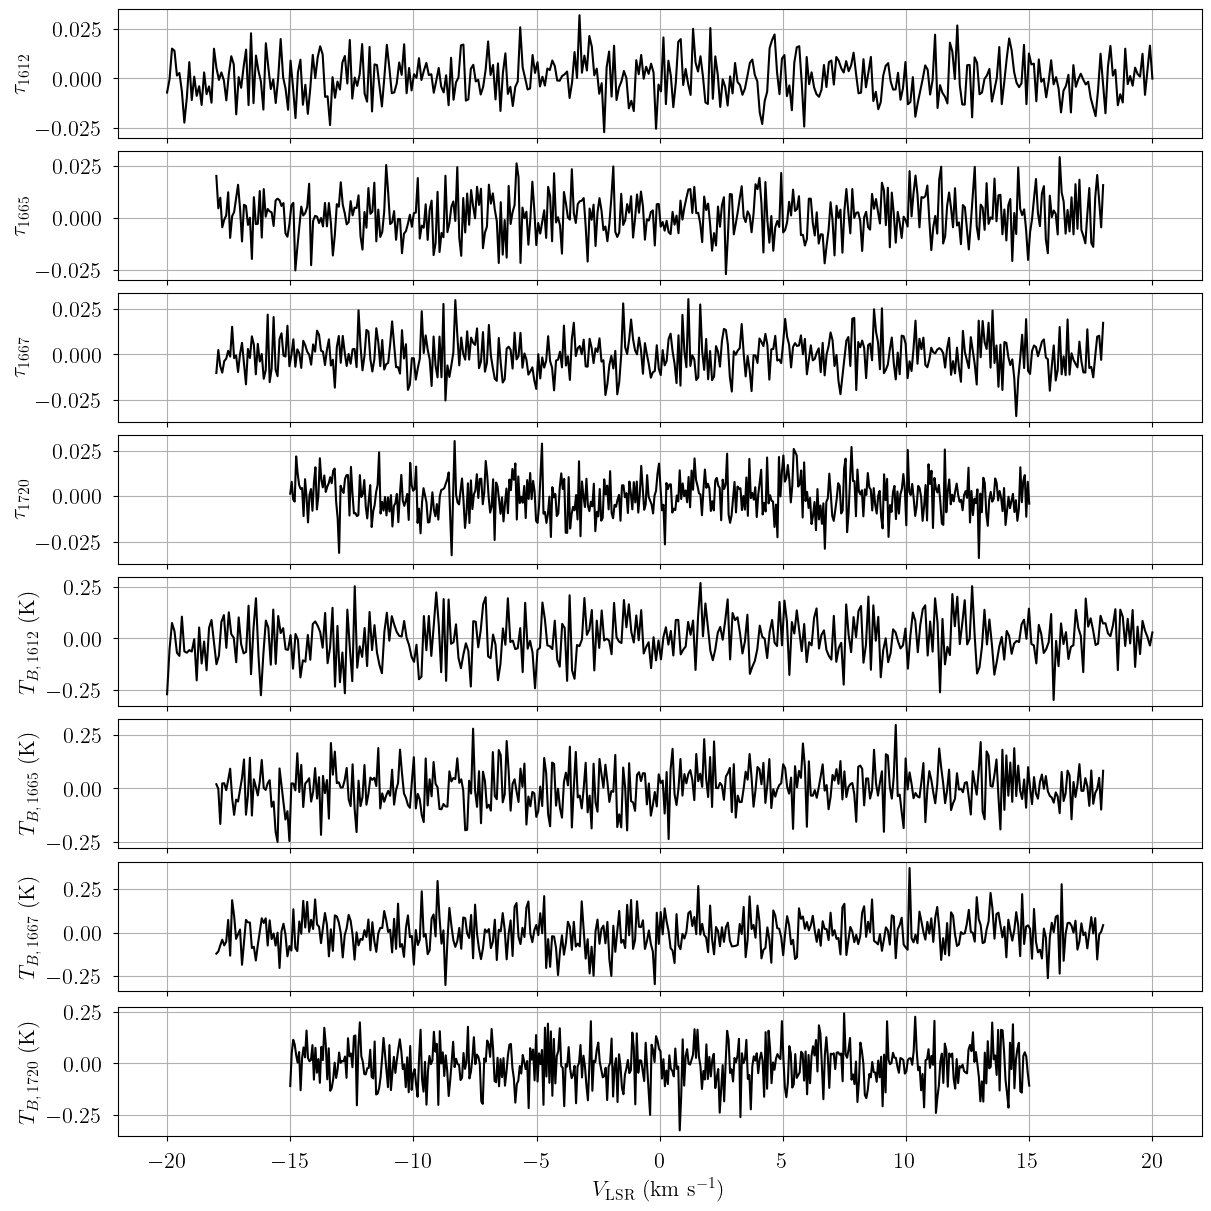

In [2]:
from bayes_spec import SpecData

# spectral axes definition
velo_axis = {
    "1612": np.linspace(-20.0, 20.0, 400), # km s-1
    "1665": np.linspace(-18.0, 18.0, 450),
    "1667": np.linspace(-18.0, 18.0, 450),
    "1720": np.linspace(-15.0, 15.0, 500),
}

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms_tau = {
    "1612": 0.01,
    "1665": 0.01,
    "1667": 0.01,
    "1720": 0.01,
}
rms_TB = {
    "1612": 0.1,
    "1665": 0.1,
    "1667": 0.1,
    "1720": 0.1,
}

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
tau = {label: rms_tau[label] * np.random.randn(len(velo_axis[label])) for label in velo_axis.keys()}
TB = {label: rms_TB[label] * np.random.randn(len(velo_axis[label])) for label in velo_axis.keys()}

# TauModel expects four observations
dummy_data = {
    f"tau_{label}": SpecData(
        velo_axis[label],
        tau[label],
        rms_tau[label],
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$\tau_{"+f"{label}"+r"}$"
    )
    for label in velo_axis.keys()
}
for label in velo_axis.keys():
    dummy_data[f"TB_{label}"] = SpecData(
        velo_axis[label],
        TB[label],
        rms_TB[label],
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_{B,\,"+f"{label}"+r"}$ (K)"
    )

# Plot dummy data
fig, axes = plt.subplots(8, sharex=True, layout="constrained", figsize=(12, 12))
for ax, dummy_datum in zip(axes, dummy_data.values()):
    ax.plot(dummy_datum.spectral, dummy_datum.brightness, "k-")
    ax.set_ylabel(dummy_datum.ylabel)
_ = axes[-1].set_xlabel(dummy_datum.xlabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the likelihood.

In [3]:
# Initialize and define the model
n_clouds = 3
baseline_degree = 2
model = TBTauModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_0 = [13.0, 1.0], # mean and width of log10(N_u) prior (cm-2)
    prior_inv_Tex = [0.0, 1.0], # mean and width of 1/Tex prior (K-1)
    prior_fwhm = 1.0, # mode of FWHM line width prior (km/s)
    prior_velocity = [0.0, 10.0], # mean and width of velocity prior (km/s)
    prior_rms_tau = 0.1, # width of spectral rms prior
    prior_rms_TB = 0.1, # width of brightness temperature rms prior (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

In [4]:
# Evaluate likelihood for given model parameters
# excitation temperature for 1612, 1665, and 1667 MHz
inv_Tex_free = np.array([
    [0.2, -0.2, 0.06], # cloud 0
    [0.06, 0.1, 0.2], # cloud 1
    [0.06, 0.06, 0.1] # cloud 2
])

sim_params = {
    "log10_N_0": np.array([14.0, 14.5, 13.5]),
    "inv_Tex_free": inv_Tex_free,
    "fwhm": np.array([1.2, 1.5, 0.8]),
    "velocity": np.array([-3.0, 1.0, 3.0]),
}

data = {}
for i, label in enumerate(velo_axis.keys()):
    # Simulate optical depth
    sim_params_label = sim_params.copy()
    sim_params_label[f"baseline_tau_{label}_norm"] = np.array([0.0, -1.0, 2.0])
    sim_params_label["rms_tau"] = np.array([0.01, 0.008, 0.012, 0.01])
    tau = model.model[f"tau_{label}"].eval(sim_params_label)
    data[f"tau_{label}"] = SpecData(
        velo_axis[label],
        tau,
        sim_params_label["rms_tau"][i],
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$\tau_{"+f"{label}"+r"}$"
    )
    
    # Simulate brightness temperature
    sim_params_label = sim_params.copy()
    sim_params_label[f"baseline_TB_{label}_norm"] = np.array([0.0, -1.0, 2.0])
    sim_params_label[f"rms_TB"] = np.array([0.1, 0.15, 0.15, 0.05])
    TB = model.model[f"TB_{label}"].eval(sim_params_label)
    data[f"TB_{label}"] = SpecData(
        velo_axis[label],
        TB,
        sim_params_label["rms_TB"][i],
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_{B,\,"+f"{label}"+r"}$"
    )

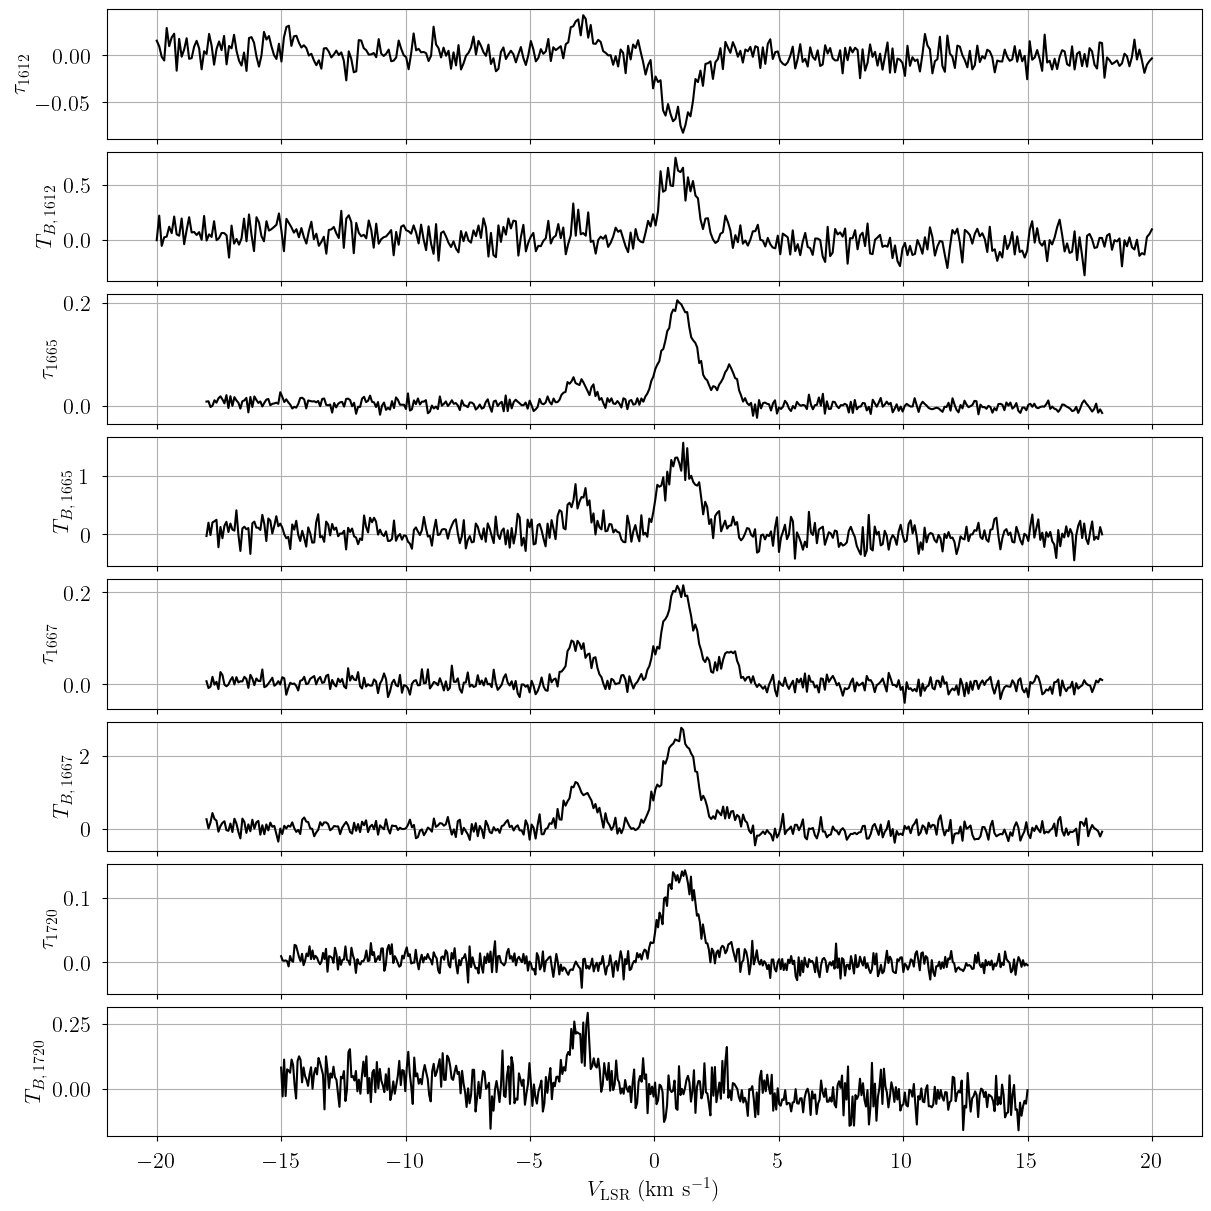

In [5]:
# Plot data
fig, axes = plt.subplots(8, sharex=True, layout="constrained", figsize=(12, 12))
for ax, datum in zip(axes, data.values()):
    ax.plot(datum.spectral, datum.brightness, "k-")
    ax.set_ylabel(datum.ylabel)
_ = axes[-1].set_xlabel(datum.xlabel)

## Model Definition

In [6]:
# Initialize and define the model
model = TBTauModel(
    data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_0 = [13.0, 1.0], # mean and width of log10(N_u) prior (cm-2)
    prior_inv_Tex = [0.5, 1.0], # mean and width of 1/Tex prior (K-1)
    prior_fwhm = 1.0, # mode of FWHM line width prior (km/s)
    prior_velocity = [0.0, 1.0], # mean and width of velocity prior (km/s)
    prior_rms_tau = 0.1, # width of spectral rms prior
    prior_rms_TB = 0.1, # width of brightness temperature rms prior (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

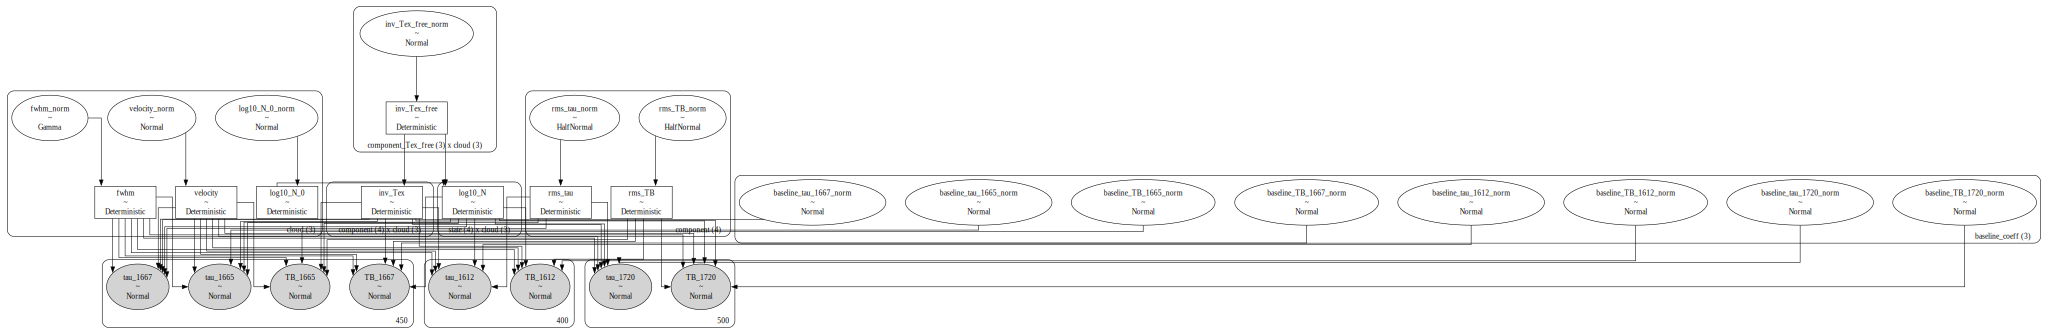

In [7]:
# Plot model graph
gviz = pm.model_to_graphviz(model.model)
gviz.graph_attr["rankdir"] = "TB"
gviz.graph_attr["splines"] = "ortho"
# gviz.graph_attr["newrank"] = "true"
gviz.graph_attr["rank"] = "same"
gviz.graph_attr["ranksep"] = "1.0"
gviz.graph_attr["nodesep"] = "0.5"
gviz.render('tb_tau_model', format='png')
gviz

In [8]:
# model string representation
print(model.model.str_repr())

baseline_tau_1612_norm ~ Normal(0, <constant>)
 baseline_TB_1612_norm ~ Normal(0, <constant>)
baseline_tau_1665_norm ~ Normal(0, <constant>)
 baseline_TB_1665_norm ~ Normal(0, <constant>)
baseline_tau_1667_norm ~ Normal(0, <constant>)
 baseline_TB_1667_norm ~ Normal(0, <constant>)
baseline_tau_1720_norm ~ Normal(0, <constant>)
 baseline_TB_1720_norm ~ Normal(0, <constant>)
        log10_N_0_norm ~ Normal(0, 1)
     inv_Tex_free_norm ~ Normal(0, 1)
             fwhm_norm ~ Gamma(2, f())
         velocity_norm ~ Normal(0, 1)
          rms_tau_norm ~ HalfNormal(0, 1)
           rms_TB_norm ~ HalfNormal(0, 1)
             log10_N_0 ~ Deterministic(f(log10_N_0_norm))
          inv_Tex_free ~ Deterministic(f(inv_Tex_free_norm))
               inv_Tex ~ Deterministic(f(inv_Tex_free_norm))
               log10_N ~ Deterministic(f(log10_N_0_norm, inv_Tex_free_norm))
                  fwhm ~ Deterministic(f(fwhm_norm))
              velocity ~ Deterministic(f(velocity_norm))
               rms_t

Sampling: [TB_1612, TB_1665, TB_1667, TB_1720, baseline_TB_1612_norm, baseline_TB_1665_norm, baseline_TB_1667_norm, baseline_TB_1720_norm, baseline_tau_1612_norm, baseline_tau_1665_norm, baseline_tau_1667_norm, baseline_tau_1720_norm, fwhm_norm, inv_Tex_free_norm, log10_N_0_norm, rms_TB_norm, rms_tau_norm, tau_1612, tau_1665, tau_1667, tau_1720, velocity_norm]


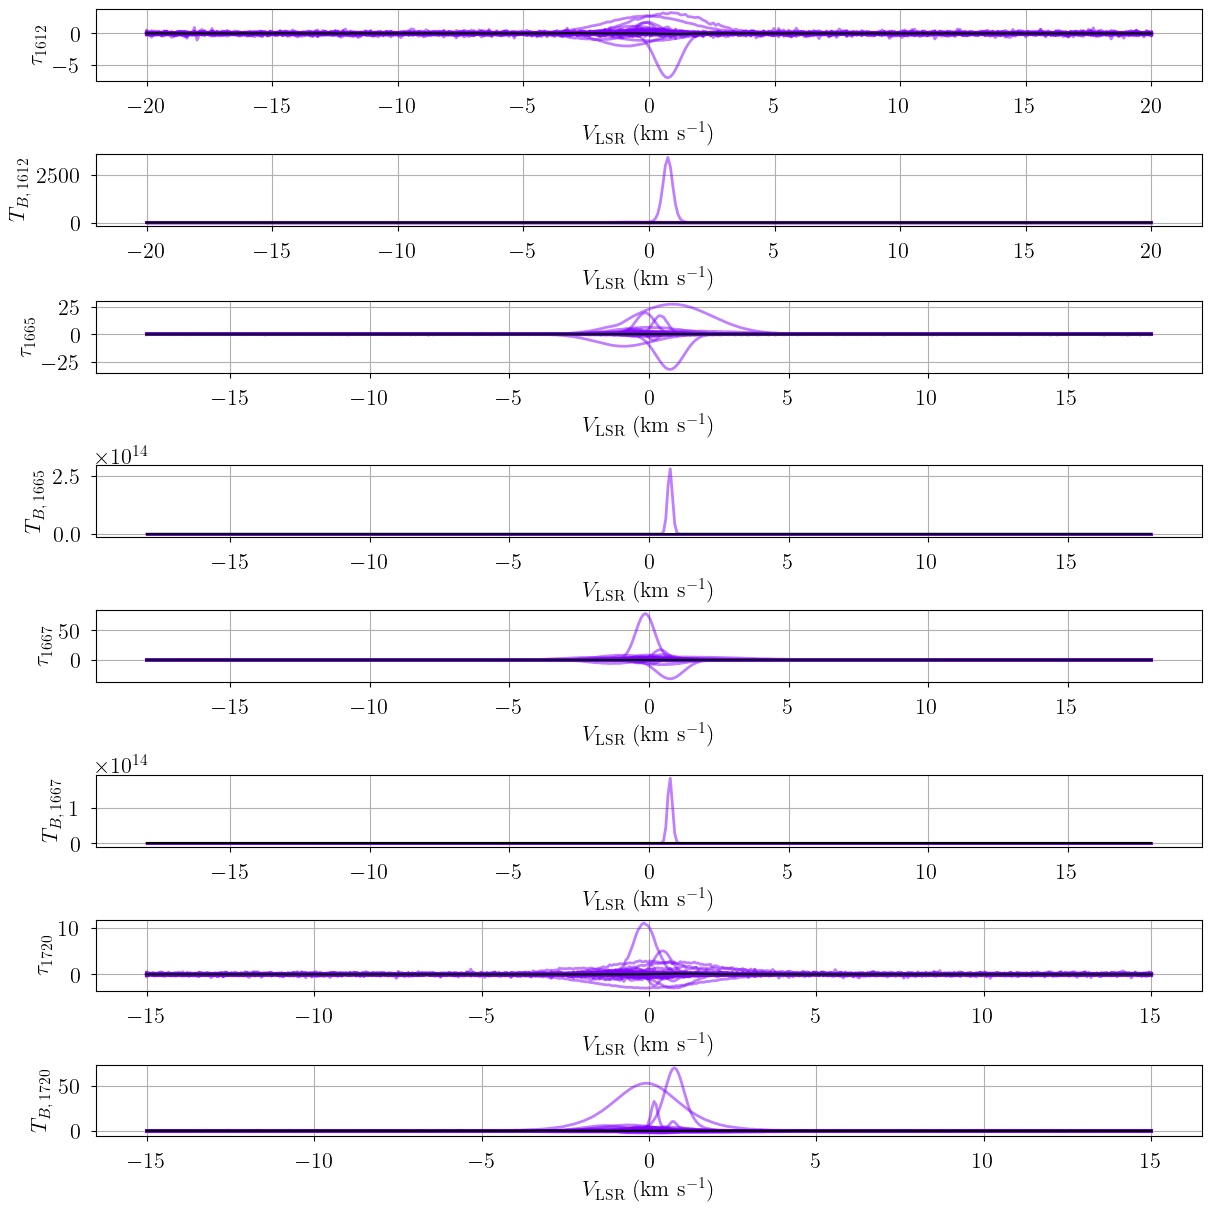

In [9]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
axes = plot_predictive(model.data, prior.prior_predictive)
axes.ravel()[0].figure.set_size_inches(12, 12)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [10]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 5600
Interrupted at 5,599 [5%]: Average Loss = 13,927


Runtime: 0.97 minutes


In [11]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
baseline_TB_1612_norm[0]    -0.157  0.037  -0.223   -0.085      0.001   
baseline_TB_1612_norm[1]    -0.877  0.117  -1.111   -0.666      0.004   
baseline_TB_1612_norm[2]     0.056  0.630  -1.105    1.141      0.020   
baseline_TB_1665_norm[0]    -0.163  0.029  -0.215   -0.107      0.001   
baseline_TB_1665_norm[1]    -0.417  0.105  -0.609   -0.227      0.003   
baseline_TB_1665_norm[2]    -1.061  0.567  -2.047    0.012      0.017   
baseline_TB_1667_norm[0]    -0.163  0.023  -0.206   -0.120      0.001   
baseline_TB_1667_norm[1]    -0.318  0.079  -0.445   -0.151      0.003   
baseline_TB_1667_norm[2]    -1.834  0.429  -2.577   -1.021      0.013   
baseline_TB_1720_norm[0]     0.044  0.045  -0.041    0.128      0.001   
baseline_TB_1720_norm[1]    -1.602  0.148  -1.874   -1.322      0.005   
baseline_TB_1720_norm[2]    -1.041  0.671  -2.222    0.277      0.021   
baseline_tau_1612_norm[0]    0.236  0.038   0.166    0.304      0.001   
baseline_tau_1612_norm[1]   -0.672  0.127  -0.907   -0.438      0.004   
baseline_tau_1612_norm[2]   -0.892  0.591  -1.956    0.283      0.019   
baseline_tau_1665_norm[0]   -0.218  0.015  -0.248   -0.193      0.001   
baseline_tau_1665_norm[1]   -0.314  0.052  -0.409   -0.207      0.002   
baseline_tau_1665_norm[2]   -1.423  0.314  -2.036   -0.865      0.010   
baseline_tau_1667_norm[0]   -0.186  0.023  -0.226   -0.141      0.001   
baseline_tau_1667_norm[1]   -0.306  0.078  -0.463   -0.169      0.003   
baseline_tau_1667_norm[2]   -1.864  0.445  -2.726   -1.051      0.015   
baseline_tau_1720_norm[0]   -0.339  0.019  -0.376   -0.307      0.001   
baseline_tau_1720_norm[1]   -0.373  0.062  -0.489   -0.262      0.002   
baseline_tau_1720_norm[2]    1.453  0.350   0.821    2.121      0.011   
fwhm[0]                      0.716  0.043   0.634    0.793      0.001   
fwhm[1]                      1.557  0.042   1.480    1.637      0.001   
fwhm[2]                      1.465  0.023   1.424    1.507      0.001   
fwhm_norm[0]                 0.716  0.043   0.634    0.793      0.001   
fwhm_norm[1]                 1.557  0.042   1.480    1.637      0.001   
fwhm_norm[2]                 1.465  0.023   1.424    1.507      0.001   
inv_Tex[1612, 0]            -0.006  0.051  -0.100    0.084      0.002   
inv_Tex[1612, 1]            -0.214  0.011  -0.235   -0.195      0.000   
inv_Tex[1612, 2]            -0.304  0.022  -0.349   -0.265      0.001   
inv_Tex[1665, 0]             0.224  0.016   0.194    0.254      0.001   
inv_Tex[1665, 1]             0.019  0.003   0.012    0.024      0.000   
inv_Tex[1665, 2]             0.325  0.006   0.313    0.336      0.000   
inv_Tex[1667, 0]             0.123  0.015   0.096    0.151      0.000   
inv_Tex[1667, 1]             0.005  0.003  -0.000    0.010      0.000   
inv_Tex[1667, 2]             0.204  0.006   0.193    0.215      0.000   
inv_Tex[1720, 0]             0.342  0.052   0.247    0.439      0.002   
inv_Tex[1720, 1]             0.224  0.011   0.205    0.245      0.000   
inv_Tex[1720, 2]             0.797  0.022   0.759    0.841      0.001   
inv_Tex_free[1612, 0]       -0.006  0.051  -0.100    0.084      0.002   
inv_Tex_free[1612, 1]       -0.214  0.011  -0.235   -0.195      0.000   
inv_Tex_free[1612, 2]       -0.304  0.022  -0.349   -0.265      0.001   
inv_Tex_free[1665, 0]        0.224  0.016   0.194    0.254      0.001   
inv_Tex_free[1665, 1]        0.019  0.003   0.012    0.024      0.000   
inv_Tex_free[1665, 2]        0.325  0.006   0.313    0.336      0.000   
inv_Tex_free[1667, 0]        0.123  0.015   0.096    0.151      0.000   
inv_Tex_free[1667, 1]        0.005  0.003  -0.000    0.010      0.000   
inv_Tex_free[1667, 2]        0.204  0.006   0.193    0.215      0.000   
inv_Tex_free_norm[1612, 0]  -0.506  0.051  -0.600   -0.416      0.002   
inv_Tex_free_norm[1612, 1]  -0.714  0.011  -0.735   -0.695      0.000   
inv_Tex_free_norm[1612, 2]  -0.804  0.022  -0.849   -0.765      0.001   
inv_Tex_free_no

Sampling: [TB_1612, TB_1665, TB_1667, TB_1720, tau_1612, tau_1665, tau_1667, tau_1720]


Output()

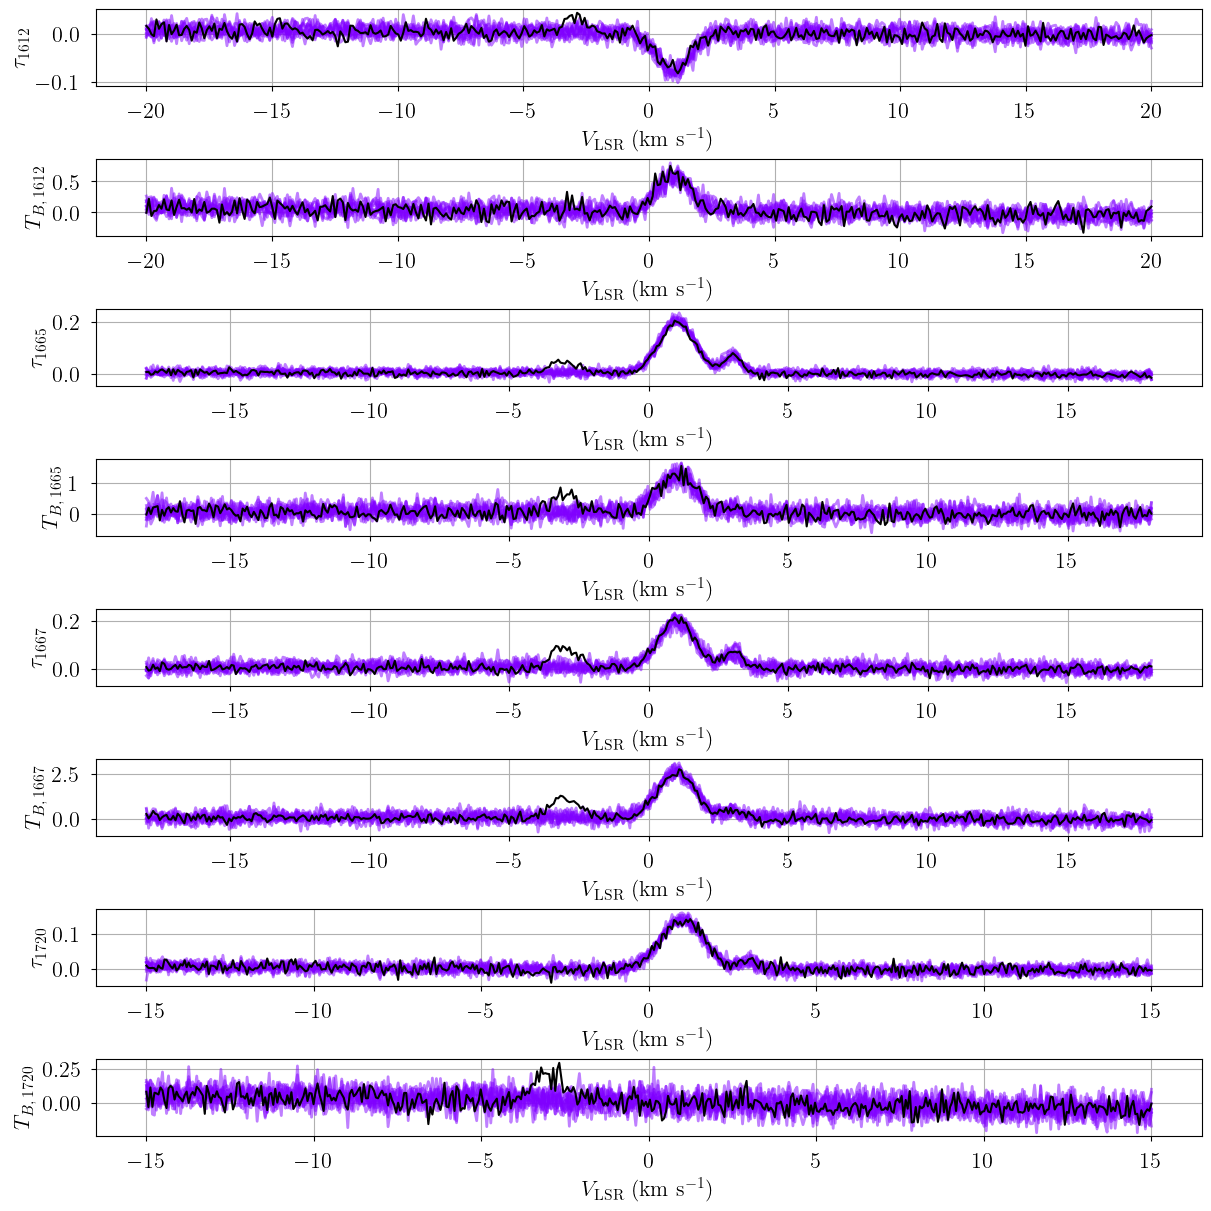

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
axes = plot_predictive(model.data, posterior.posterior_predictive)
axes.ravel()[0].figure.set_size_inches(12, 12)

Notice that VI failed to identify the lowest velocity cloud!

## Posterior Sampling: MCMC

Since this model does not have a strong degeneracy between column density and excitation temperature, we can use the default `tune=1000` and `target_accept=0.8`.

In [13]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5600
Interrupted at 5,599 [5%]: Average Loss = 13,927
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_tau_1612_norm, baseline_TB_1612_norm, baseline_tau_1665_norm, baseline_TB_1665_norm, baseline_tau_1667_norm, baseline_TB_1667_norm, baseline_tau_1720_norm, baseline_TB_1720_norm, log10_N_0_norm, inv_Tex_free_norm, fwhm_norm, velocity_norm, rms_tau_norm, rms_TB_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 263 seconds.


Runtime: 6.37 minutes


In [14]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


In [15]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
baseline_TB_1612_norm[0]    -0.210  0.042  -0.291   -0.135      0.001   
baseline_TB_1612_norm[1]    -0.870  0.109  -1.076   -0.667      0.001   
baseline_TB_1612_norm[2]     0.523  0.699  -0.801    1.858      0.009   
baseline_TB_1665_norm[0]    -0.338  0.035  -0.405   -0.272      0.000   
baseline_TB_1665_norm[1]    -0.375  0.084  -0.531   -0.215      0.001   
baseline_TB_1665_norm[2]     0.930  0.618  -0.243    2.062      0.008   
baseline_TB_1667_norm[0]    -0.368  0.023  -0.409   -0.322      0.000   
baseline_TB_1667_norm[1]    -0.266  0.049  -0.366   -0.179      0.001   
baseline_TB_1667_norm[2]     0.605  0.421  -0.203    1.354      0.006   
baseline_TB_1720_norm[0]    -0.190  0.045  -0.276   -0.107      0.001   
baseline_TB_1720_norm[1]    -1.482  0.113  -1.701   -1.280      0.001   
baseline_TB_1720_norm[2]     1.129  0.731  -0.363    2.384      0.009   
baseline_tau_1612_norm[0]    0.117  0.040   0.043    0.193      0.001   
baseline_tau_1612_norm[1]   -0.625  0.103  -0.820   -0.433      0.001   
baseline_tau_1612_norm[2]    0.217  0.679  -1.036    1.511      0.009   
baseline_tau_1665_norm[0]   -0.349  0.018  -0.384   -0.316      0.000   
baseline_tau_1665_norm[1]   -0.277  0.035  -0.344   -0.215      0.000   
baseline_tau_1665_norm[2]    0.271  0.326  -0.369    0.846      0.004   
baseline_tau_1667_norm[0]   -0.367  0.024  -0.412   -0.319      0.000   
baseline_tau_1667_norm[1]   -0.234  0.048  -0.329   -0.149      0.000   
baseline_tau_1667_norm[2]    0.360  0.427  -0.424    1.155      0.006   
baseline_tau_1720_norm[0]   -0.306  0.025  -0.356   -0.261      0.000   
baseline_tau_1720_norm[1]   -0.395  0.060  -0.507   -0.285      0.001   
baseline_tau_1720_norm[2]    1.071  0.460   0.209    1.920      0.006   
fwhm[0]                      0.769  0.036   0.704    0.839      0.000   
fwhm[1]                      1.522  0.015   1.493    1.551      0.000   
fwhm[2]                      1.205  0.038   1.140    1.282      0.000   
fwhm_norm[0]                 0.769  0.036   0.704    0.839      0.000   
fwhm_norm[1]                 1.522  0.015   1.493    1.551      0.000   
fwhm_norm[2]                 1.205  0.038   1.140    1.282      0.000   
inv_Tex[1612, 0]             0.036  0.033  -0.025    0.097      0.000   
inv_Tex[1612, 1]            -0.210  0.005  -0.220   -0.200      0.000   
inv_Tex[1612, 2]             0.199  0.015   0.172    0.228      0.000   
inv_Tex[1665, 0]             0.176  0.014   0.152    0.203      0.000   
inv_Tex[1665, 1]             0.100  0.002   0.097    0.103      0.000   
inv_Tex[1665, 2]             0.059  0.003   0.052    0.065      0.000   
inv_Tex[1667, 0]             0.102  0.009   0.086    0.119      0.000   
inv_Tex[1667, 1]             0.061  0.001   0.059    0.063      0.000   
inv_Tex[1667, 2]             0.060  0.003   0.055    0.065      0.000   
inv_Tex[1720, 0]             0.236  0.032   0.177    0.295      0.000   
inv_Tex[1720, 1]             0.353  0.006   0.341    0.363      0.000   
inv_Tex[1720, 2]            -0.072  0.013  -0.098   -0.049      0.000   
inv_Tex_free[1612, 0]        0.036  0.033  -0.025    0.097      0.000   
inv_Tex_free[1612, 1]       -0.210  0.005  -0.220   -0.200      0.000   
inv_Tex_free[1612, 2]        0.199  0.015   0.172    0.228      0.000   
inv_Tex_free[1665, 0]        0.176  0.014   0.152    0.203      0.000   
inv_Tex_free[1665, 1]        0.100  0.002   0.097    0.103      0.000   
inv_Tex_free[1665, 2]        0.059  0.003   0.052    0.065      0.000   
inv_Tex_free[1667, 0]        0.102  0.009   0.086    0.119      0.000   
inv_Tex_free[1667, 1]        0.061  0.001   0.059    0.063      0.000   
inv_Tex_free[1667, 2]        0.060  0.003   0.055    0.065      0.000   
inv_Tex_free_norm[1612, 0]  -0.464  0.033  -0.525   -0.403      0.000   
inv_Tex_free_norm[1612, 1]  -0.710  0.005  -0.720   -0.700      0.000   
inv_Tex_free_norm[1612, 2]  -0.301  0.015  -0.328   -0.272      0.000   
inv_Tex_free_no

Sampling: [TB_1612, TB_1665, TB_1667, TB_1720, tau_1612, tau_1665, tau_1667, tau_1720]


Output()

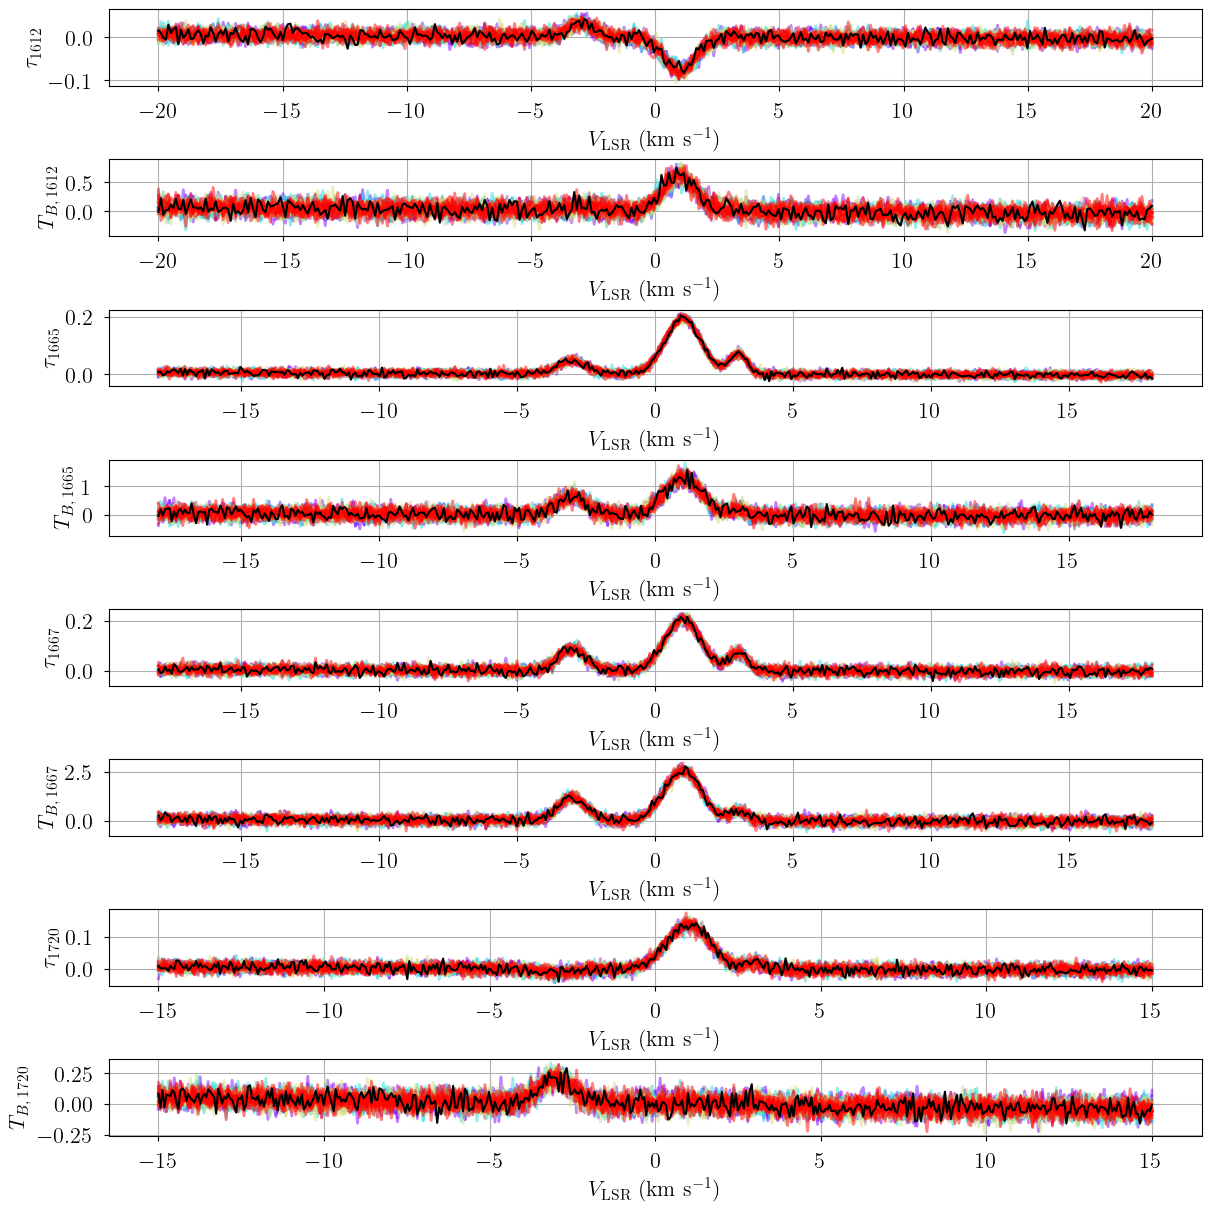

In [16]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
axes = plot_predictive(model.data, posterior.posterior_predictive)
axes.ravel()[0].figure.set_size_inches(12, 12)

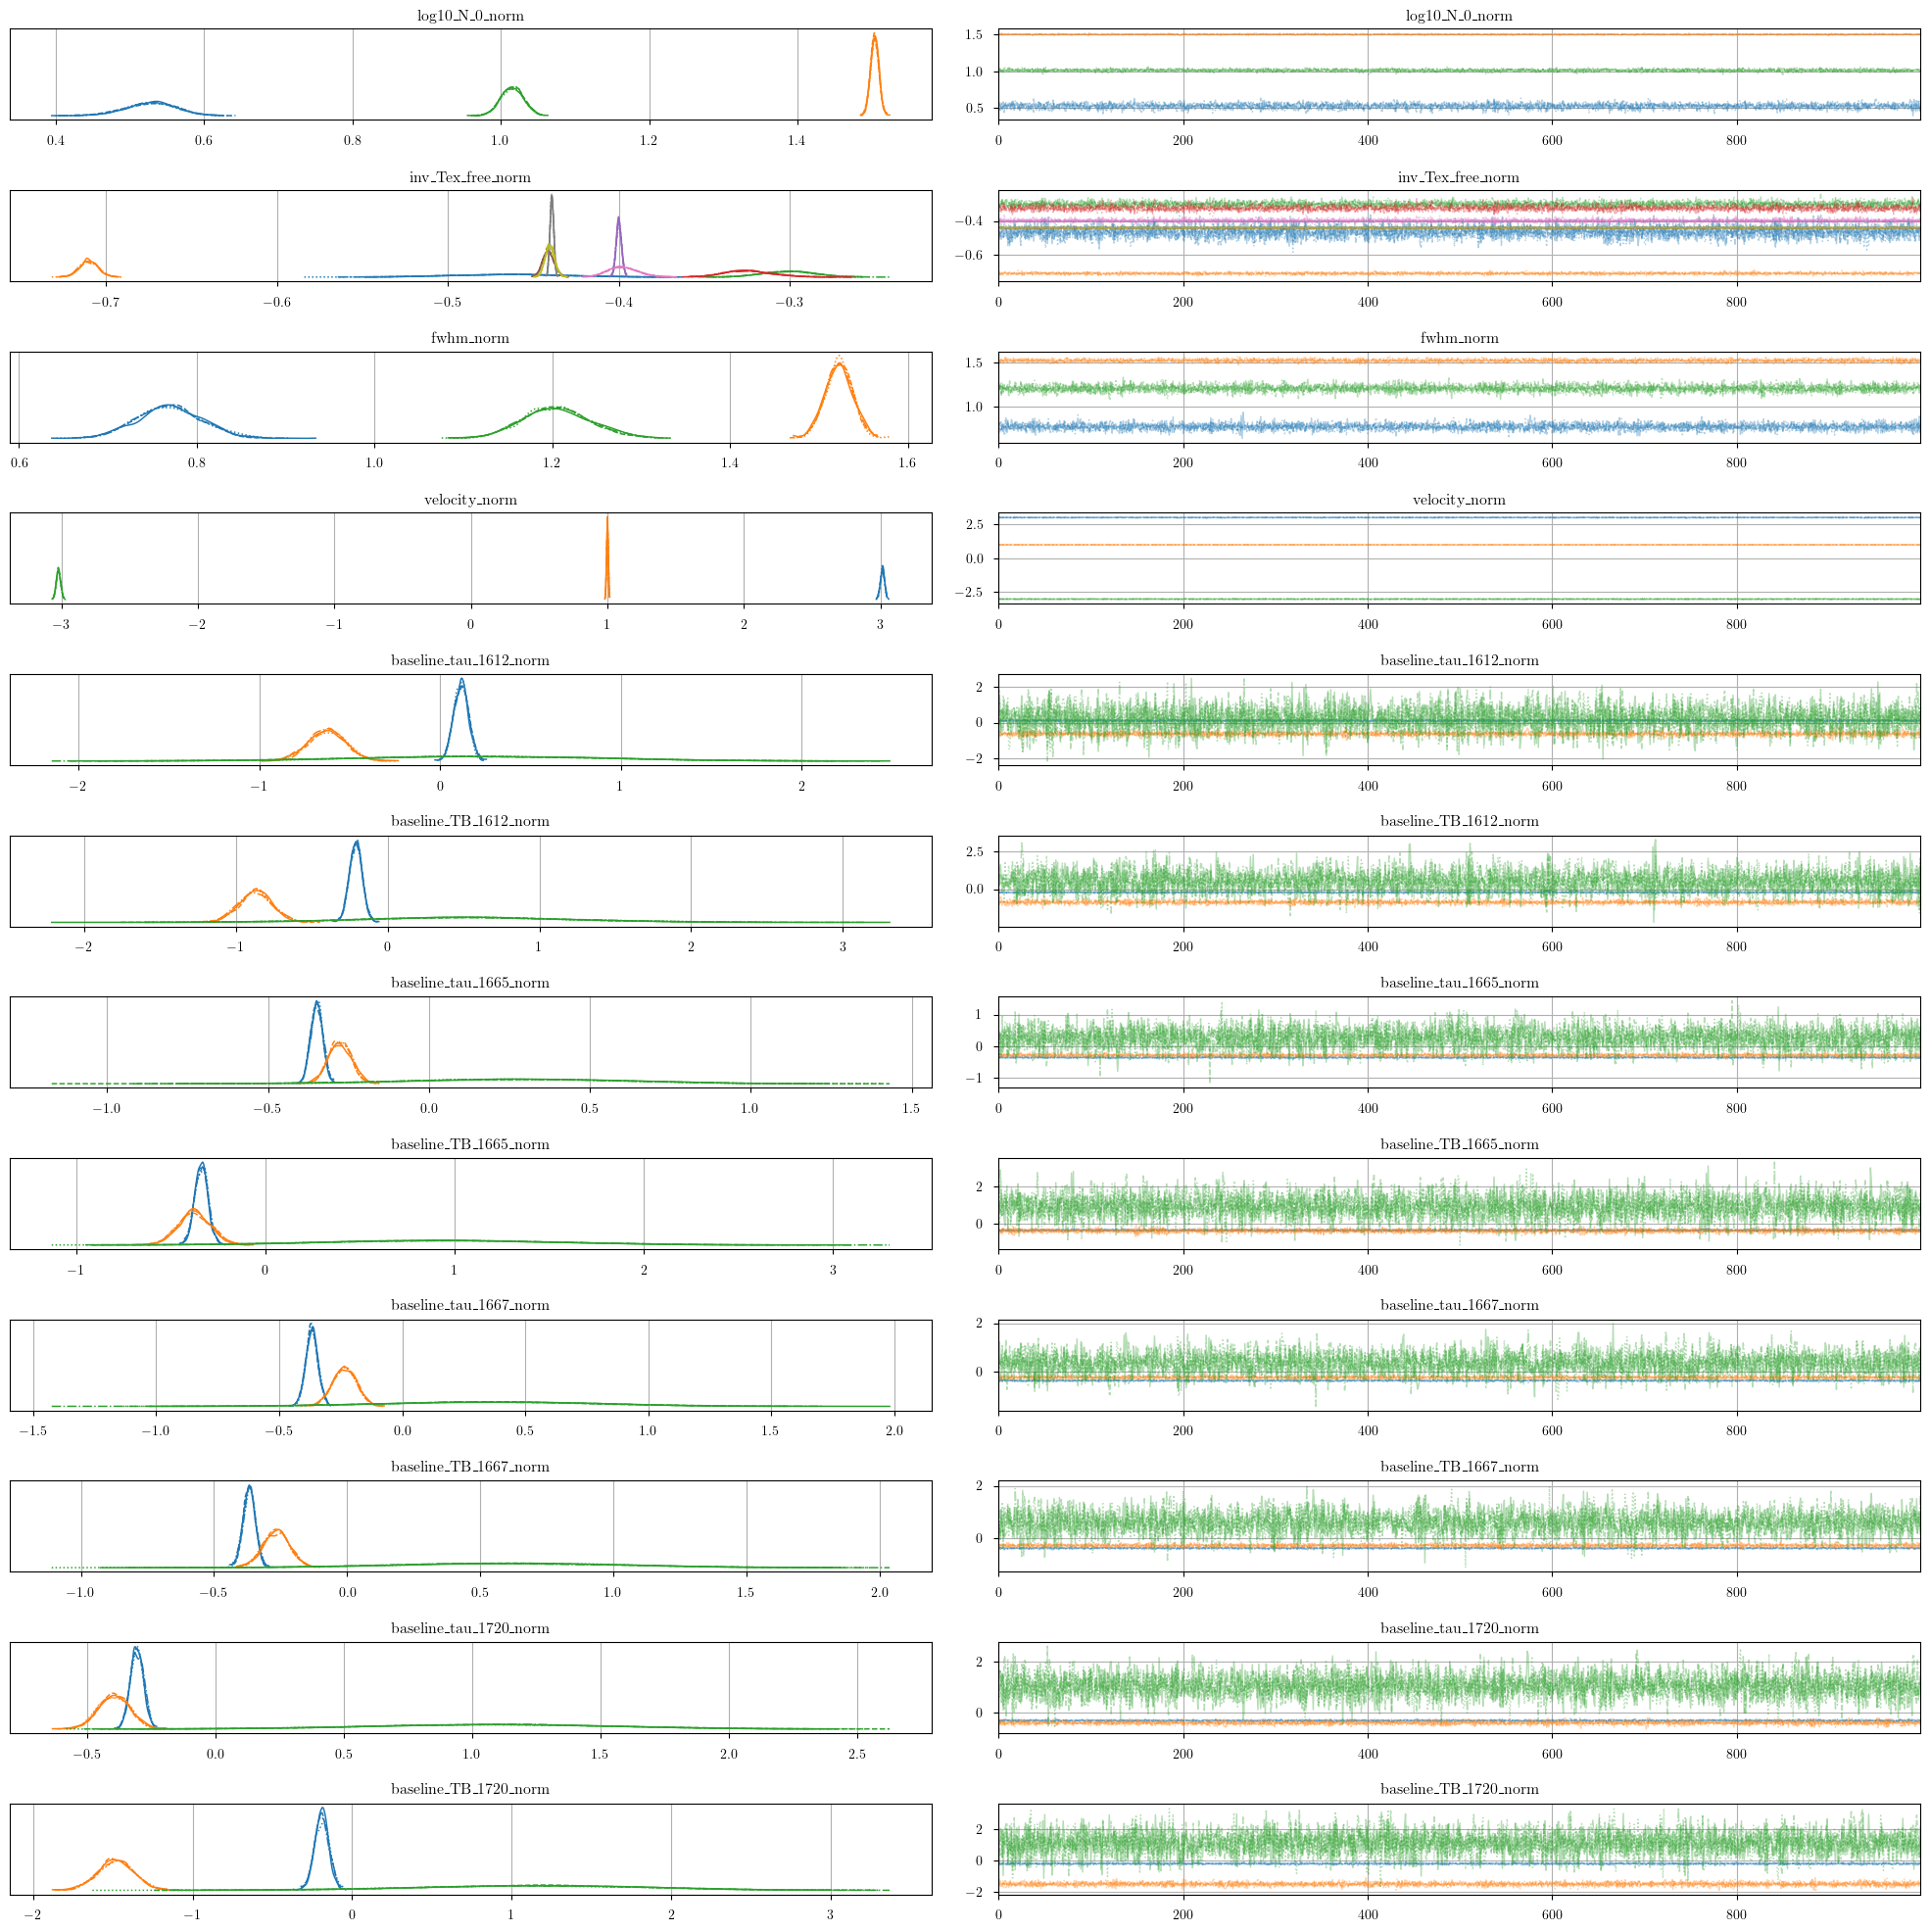

In [17]:
from bayes_spec.plots import plot_traces

axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
axes.ravel()[0].figure.set_size_inches(20, 20)
axes.ravel()[0].figure.tight_layout()

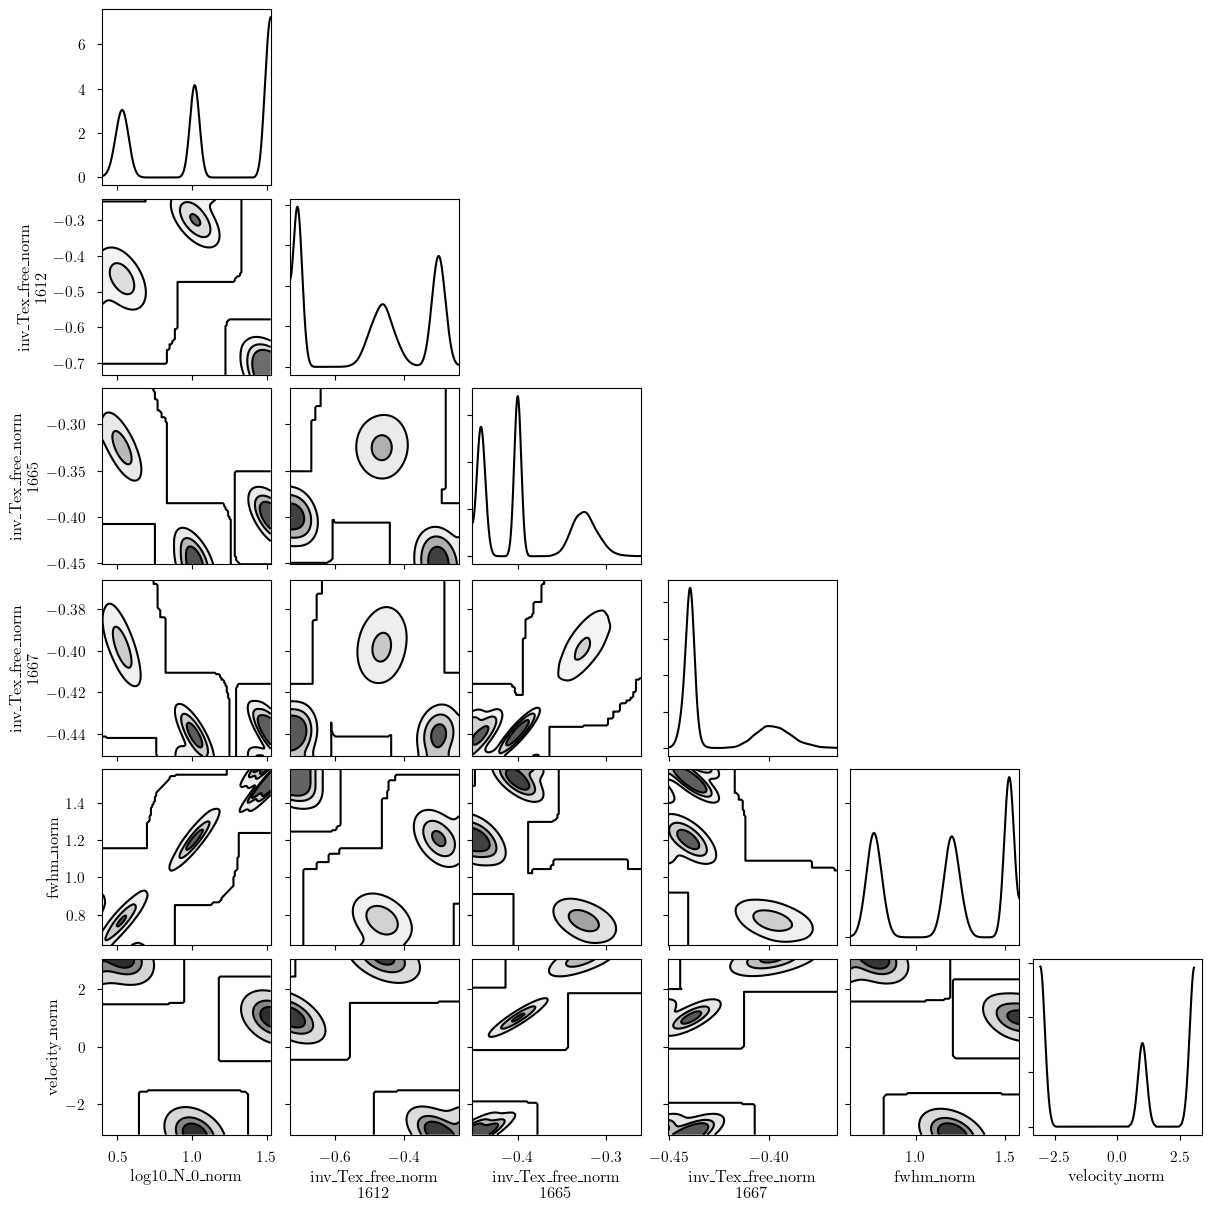

In [18]:
from bayes_spec.plots import plot_pair

axes = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)
axes.ravel()[0].figure.set_size_inches(12, 12)

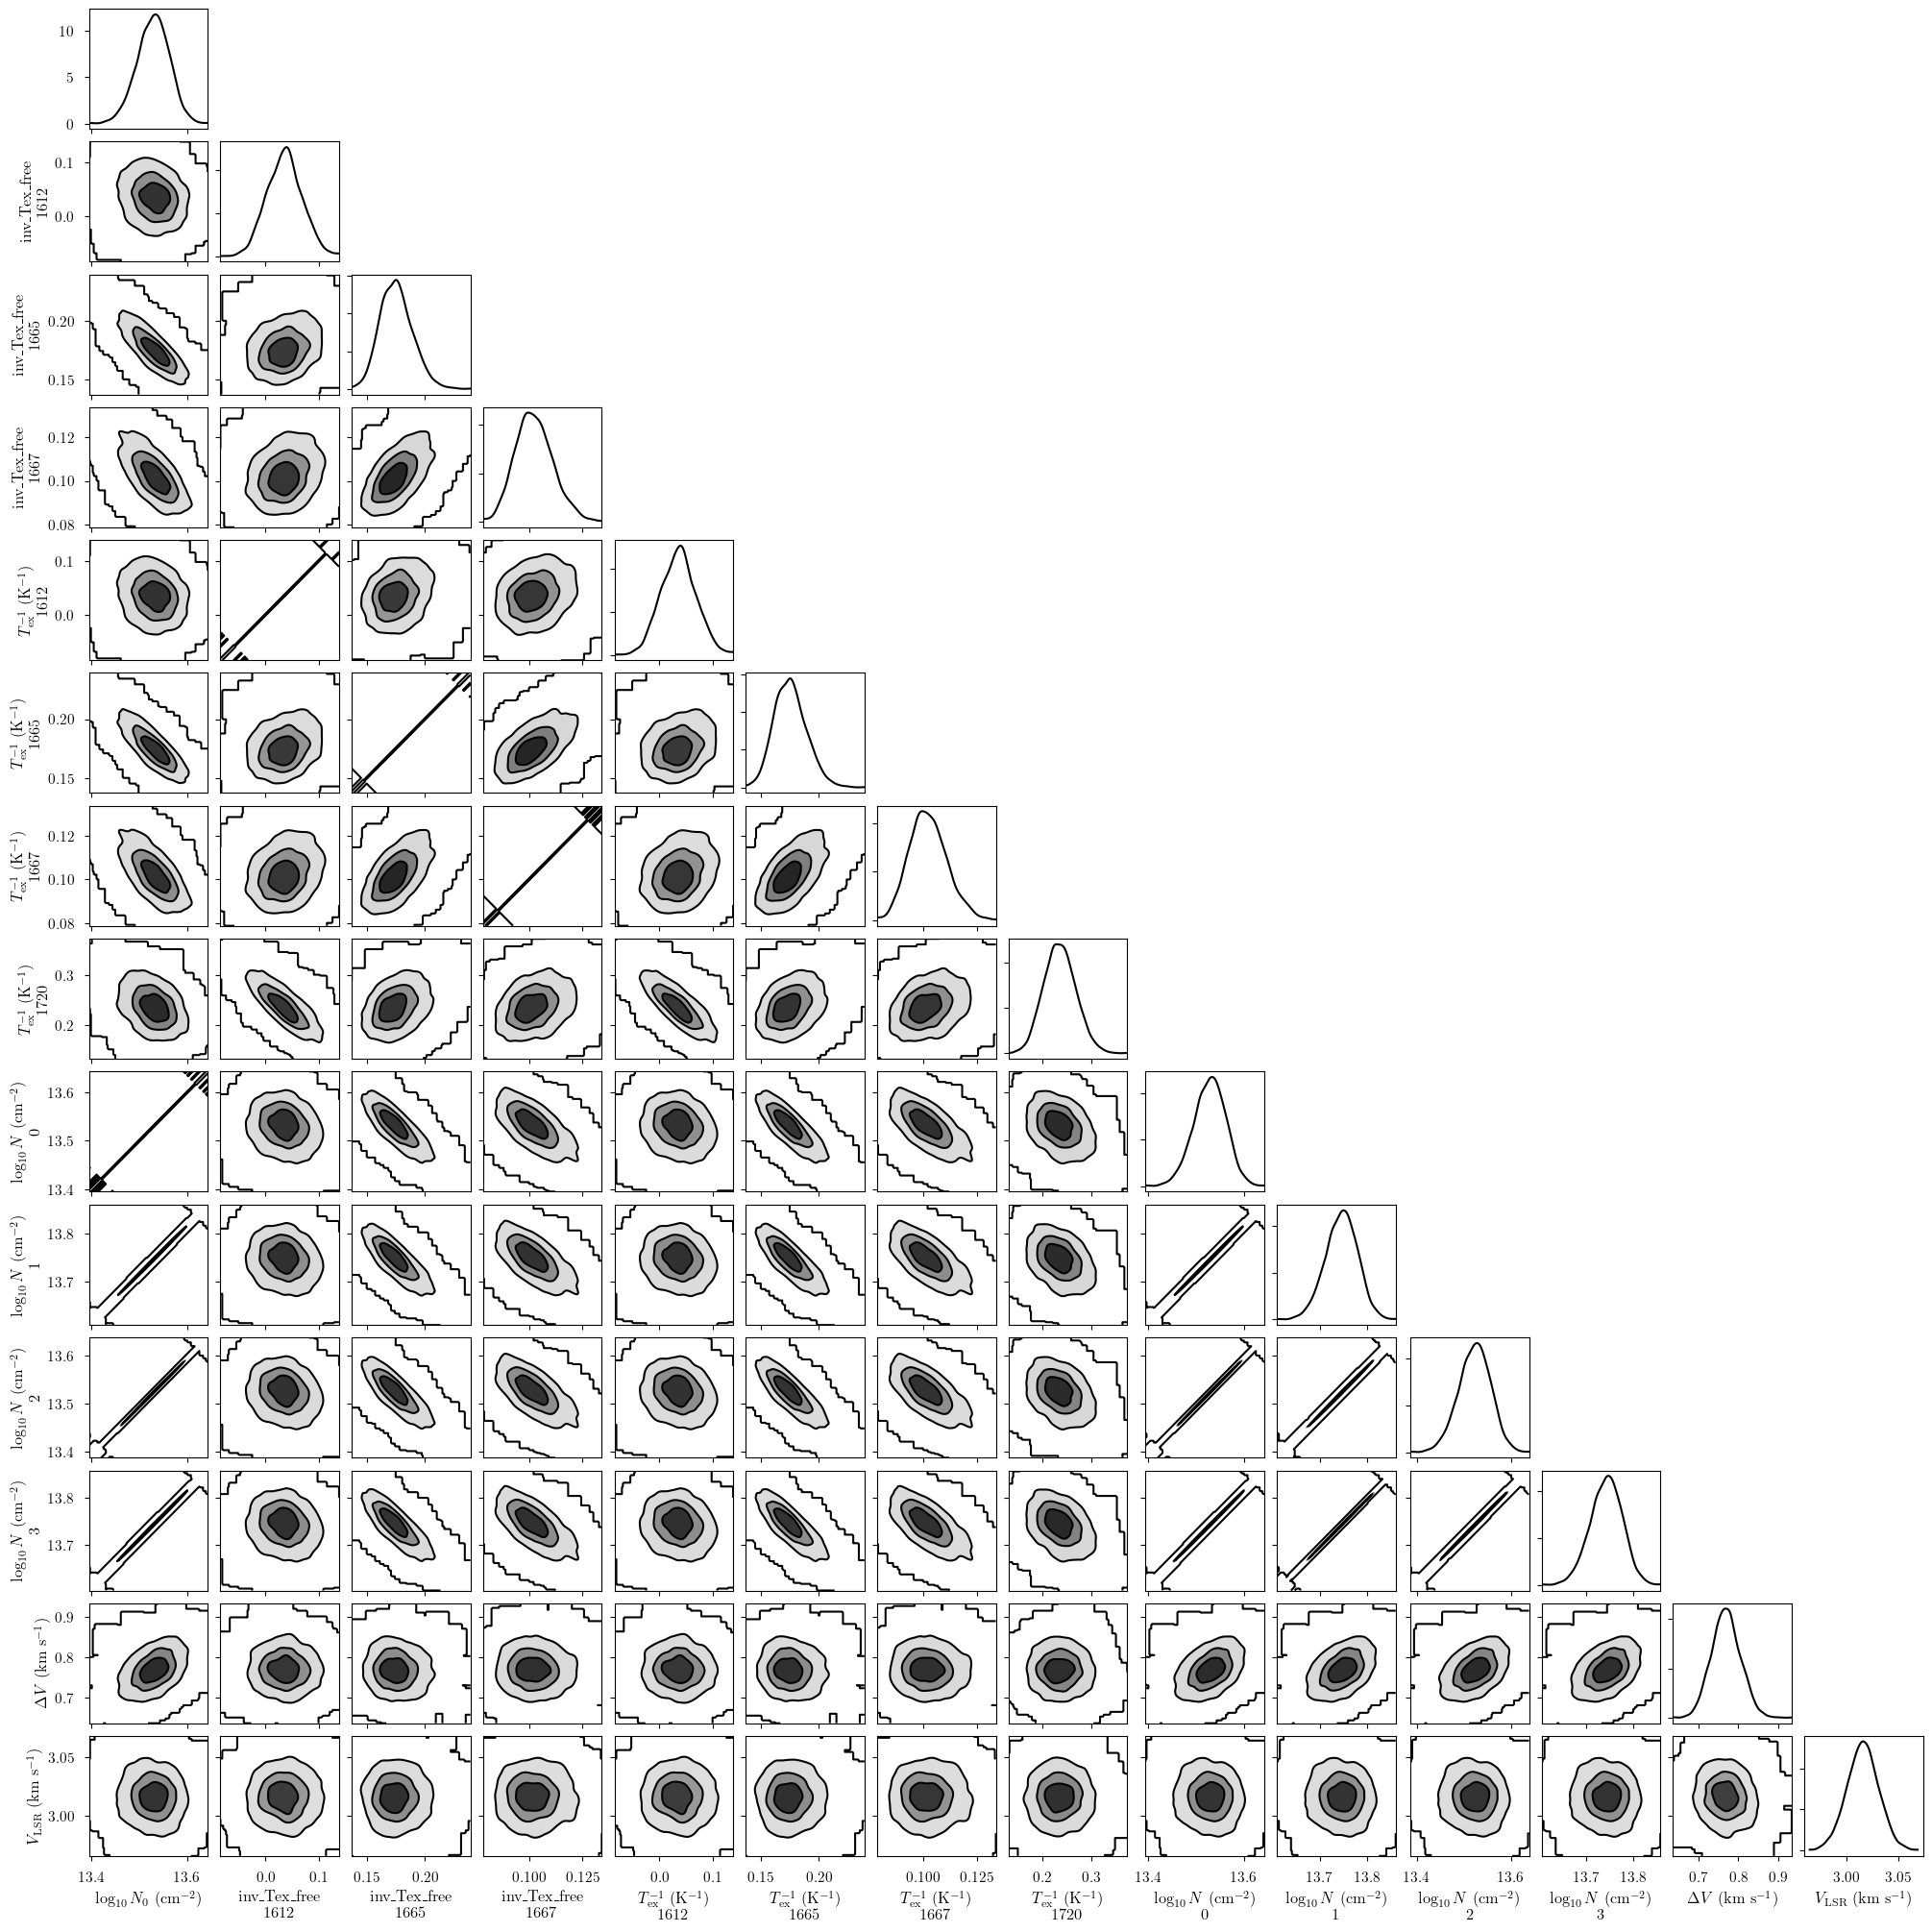

In [19]:
axes = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)
axes.ravel()[0].figure.set_size_inches(20, 20)

In [20]:
point_stats = az.summary(model.trace.solution_0, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
point_stats

BIC: -14102.121927020295


mean     sd  hdi_16%  hdi_84%
baseline_TB_1612_norm[0]    -0.210  0.042   -0.249   -0.168
baseline_TB_1612_norm[1]    -0.870  0.109   -0.989   -0.774
baseline_TB_1612_norm[2]     0.523  0.699   -0.137    1.227
baseline_TB_1665_norm[0]    -0.338  0.035   -0.369   -0.301
baseline_TB_1665_norm[1]    -0.375  0.084   -0.461   -0.292
baseline_TB_1665_norm[2]     0.930  0.618    0.310    1.530
baseline_TB_1667_norm[0]    -0.368  0.023   -0.390   -0.345
baseline_TB_1667_norm[1]    -0.266  0.049   -0.317   -0.220
baseline_TB_1667_norm[2]     0.605  0.421    0.184    1.015
baseline_TB_1720_norm[0]    -0.190  0.045   -0.236   -0.148
baseline_TB_1720_norm[1]    -1.482  0.113   -1.582   -1.362
baseline_TB_1720_norm[2]     1.129  0.731    0.357    1.804
baseline_tau_1612_norm[0]    0.117  0.040    0.077    0.156
baseline_tau_1612_norm[1]   -0.625  0.103   -0.728   -0.526
baseline_tau_1612_norm[2]    0.217  0.679   -0.380    0.955
baseline_tau_1665_norm[0]   -0.349  0.018   -0.367   -0.330
baseline_tau_1665_norm[1]   -0.277  0.035   -0.311   -0.242
baseline_tau_1665_norm[2]    0.271  0.326   -0.056    0.597
baseline_tau_1667_norm[0]   -0.367  0.024   -0.392   -0.344
baseline_tau_1667_norm[1]   -0.234  0.048   -0.286   -0.191
baseline_tau_1667_norm[2]    0.360  0.427   -0.067    0.778
baseline_tau_1720_norm[0]   -0.306  0.025   -0.330   -0.280
baseline_tau_1720_norm[1]   -0.395  0.060   -0.449   -0.330
baseline_tau_1720_norm[2]    1.071  0.460    0.560    1.479
fwhm[0]                      0.769  0.036    0.731    0.804
fwhm[1]                      1.522  0.015    1.506    1.537
fwhm[2]                      1.205  0.038    1.165    1.239
fwhm_norm[0]                 0.769  0.036    0.731    0.804
fwhm_norm[1]                 1.522  0.015    1.506    1.537
fwhm_norm[2]                 1.205  0.038    1.165    1.239
inv_Tex[1612, 0]             0.036  0.033    0.003    0.069
inv_Tex[1612, 1]            -0.210  0.005   -0.215   -0.204
inv_Tex[1612, 2]             0.199  0.015    0.185    0.215
inv_Tex[1665, 0]             0.176  0.014    0.161    0.188
inv_Tex[1665, 1]             0.100  0.002    0.098    0.101
inv_Tex[1665, 2]             0.059  0.003    0.055    0.062
inv_Tex[1667, 0]             0.102  0.009    0.092    0.109
inv_Tex[1667, 1]             0.061  0.001    0.060    0.062
inv_Tex[1667, 2]             0.060  0.003    0.057    0.063
inv_Tex[1720, 0]             0.236  0.032    0.202    0.265
inv_Tex[1720, 1]             0.353  0.006    0.347    0.358
inv_Tex[1720, 2]            -0.072  0.013   -0.085   -0.060
inv_Tex_free[1612, 0]        0.036  0.033    0.003    0.069
inv_Tex_free[1612, 1]       -0.210  0.005   -0.215   -0.204
inv_Tex_free[1612, 2]        0.199  0.015    0.185    0.215
inv_Tex_free[1665, 0]        0.176  0.014    0.161    0.188
inv_Tex_free[1665, 1]        0.100  0.002    0.098    0.101
inv_Tex_free[1665, 2]        0.059  0.003    0.055    0.062
inv_Tex_free[1667, 0]        0.102  0.009    0.092    0.109
inv_Tex_free[1667, 1]        0.061  0.001    0.060    0.062
inv_Tex_free[1667, 2]        0.060  0.003    0.057    0.063
inv_Tex_free_norm[1612, 0]  -0.464  0.033   -0.497   -0.431
inv_Tex_free_norm[1612, 1]  -0.710  0.005   -0.715   -0.704
inv_Tex_free_norm[1612, 2]  -0.301  0.015   -0.315   -0.285
inv_Tex_free_norm[1665, 0]  -0.324  0.014   -0.339   -0.312
inv_Tex_free_norm[1665, 1]  -0.400  0.002   -0.402   -0.399
inv_Tex_free_norm[1665, 2]  -0.441  0.003   -0.445   -0.438
inv_Tex_free_norm[1667, 0]  -0.398  0.009   -0.408   -0.391
inv_Tex_free_norm[1667, 1]  -0.439  0.001   -0.440   -0.438
inv_Tex_free_norm[1667, 2]  -0.440  0.003   -0.443   -0.437
log10_N[0, 0]               13.528  0.033   13.499   13.565
log10_N[0, 1]               14.504  0.006   14.499   14.510
log10_N[0, 2]               14.015  0.015   14.000   14.030
log10_N[1, 0]               13.745  0.034   13.716   13.783
log10_N[1, 1]               14.715  0.006   14.710   14.721
log10_N[1, 2]               14.242  0.015   14.226   14.256
log10_N[2,